# Averaging Model Approach

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score
import joblib
import warnings
warnings.filterwarnings("ignore") 

## Data Loading and Preprocessing

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
final_train = train.copy()
final_test = test.copy()

In [6]:
def clean_categorical(data):
    cat_features = []
    Binary_features = []
    
    # Collect the categorical and binary feature names 
    for f in data.columns:
        if data[f].dtype == 'object':
            cat_features.append(f)
        elif data[f].dtype == 'int' and f != 'ID':
            Binary_features.append(f)
    
    cat_df = data[cat_features]
    oe = OrdinalEncoder()
    enc_cat_df = oe.fit_transform(cat_df)
    enc_df = pd.DataFrame(enc_cat_df,columns=cat_features)
    enc_df.insert(0, 'ID', data['ID'].values)
    binary_df = data.drop(['X0', 'X1', 'X2', 'X3', 'X4','X5', 'X6', 'X8'],axis=1)
    for col in data.columns:
        if col=='y':
            binary_df = binary_df.drop(['y'],axis=1)
            break
            
    final_df = pd.merge(enc_df,binary_df,on='ID',how='left')
    
    return final_df.drop(['ID'],axis=1)

In [7]:
X_train =  clean_categorical(final_train)
X_test =  clean_categorical(final_test)

y_train = final_train['y']

## New Averaging Model

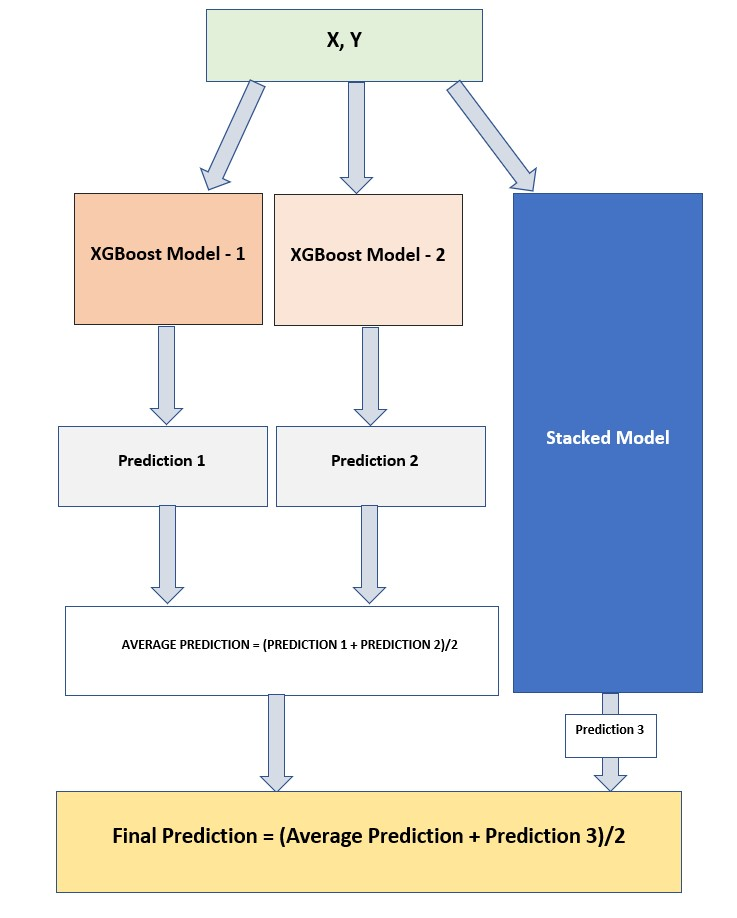

In [8]:
def predict(train_data,y_train,test_data):
    
    # get the mean target value
    y_mean = np.mean(y_train)
    # set the seed for reproducing results
    np.random.seed(2)
    
    print('Fitting 1st model')
    model_1 = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4, monotone_constraints='()', n_estimators=150,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.1)
    
    model_1.fit(train_data,y_train)
    # predict target values for train data
    y_tr_pred1 = model_1.predict(train_data)
    # predict target values for test data
    p1 = model_1.predict(test_data)
    # save the model to the disk for future use
    filename = "C:/Users/gaura/Desktop/final_best_model1_xgb.pkl"
    model_2 = joblib.dump(model_1, filename)
    print(f'Saved {filename}')
    print("Done.")
    
    # create parameters list for second xgboost model
    xgb_params = {'eta': 0.0045,
                    'max_depth': 4,
                    'subsample': 0.93,
                    'eval_metric': 'rmse',
                    'base_score': y_mean, # base prediction = mean(target)
                    'colsample_bytree': 0.7,
                    'seed': 2}
    num_boost_rounds = 1250
    
    # create xgb ready data 
    dtrain = xgb.DMatrix(train_data, y_train)
    dtest = xgb.DMatrix(test_data)
    # train xgb model 2 
    print("Fitting second model...")
    model_2 = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)
    # predict target values for train data
    y_tr_pred2 = model_2.predict(dtrain)
    # predict target values for test data
    p2 = model_2.predict(dtest)
    # save the model to the disk for future use
    filename = "C:/Users/gaura/Desktop/final_best_model2_xgb.pkl"
    model_2 = joblib.dump(model_2, filename)
    print(f'Saved {filename}')
    print("Done.")
    
    # average the predictions for train data by both models and calculate the r2_score
    avg_pred_train = (y_tr_pred1+y_tr_pred2)/2
    
    # average the predictions for test data by model 1 and model 2
    final_pred_test = (p1+p2)/2
    #load model 3
    print("Fitting Third model...")    
    model_3 = joblib.load('Stacked_combined_new_feat_model.sav')
    model_3.fit(train_data,y_train)
    y_tr_pred3 = model_3.predict(train_data)
    # predict target values for test data
    p3 = model_3.predict(test_data)
    # save the model to the disk for future use
    filename = "C:/Users/gaura/Desktop/final_best_model3_stacked.pkl"
    model_3 = joblib.dump(model_3, filename)
    print(f'Saved {filename}')
    print("Done.")
    
    avg_pred = (y_tr_pred3 + avg_pred_train)/2
    print(r2_score(y_train,avg_pred))
    #final prediction: taking averaged models of 1 and 2 as output and aveaging the output with stacked model output
    final_pred = (final_pred_test + p3)/2
    # create pandas series for storing predictions
    pred_test = pd.Series()
    pred_test['y'] = final_pred
    # return the final averaged predictions
    return pred_test['y']

In [9]:
predictions = predict(X_train,y_train,X_test)

Fitting 1st model
Saved C:/Users/gaura/Desktop/final_best_model1_xgb.pkl
Done.
Fitting second model...
Saved C:/Users/gaura/Desktop/final_best_model2_xgb.pkl
Done.
Fitting Third model...
Saved C:/Users/gaura/Desktop/final_best_model3_stacked.pkl
Done.
0.6168468250731844


In [10]:
submission_final = pd.read_csv('sample_submission.csv')
submission_final['y'] = predictions
submission_final.to_csv(f'C:/Users/gaura/Desktop/final_submission_avg_of_XGB_Combined_with_Stack.csv', index=False)
submission_final.head(10)

,ID,y
0,1,81.688088
1,2,98.734626
2,3,81.990387
3,4,77.708994
4,5,110.908714
5,8,91.965489
6,10,110.368420
7,11,94.459852
8,12,116.407521
9,14,94.238174


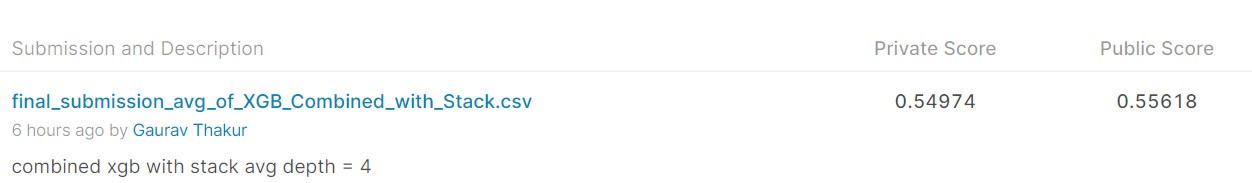